# Prototyping Code for Flight Path Vizualizer

## 1. Loading OpenSky Data

This requires you to actively have credentials to access the Opensky DataBase, please check the [wiki page](https://github.com/Andrerg01/FlightPathAnalysis/wiki/Basic-OpenSky-Data-Usage) for more informaiton

### 1.1 Downloading Flights Information Data

This method allows you to download information about all flights withing a certain date range given an origin airport and a destination airport. 

Please refer to the [List of airports by IATA airport code](https://en.wikipedia.org/wiki/List_of_airports_by_IATA_airport_code:_A) for the precise IATA code of all airports.

The result is given as a pandas dataframe, containing 4 columns of interest (among some more)
 - firstseen: The UNIX UTC time the aircraft was first seen
 - lastseen: The UNIC UTC time the aircraft was last seen
 - icao24: The icao24 identification nunber of the airfract
 - callsign: The callsign of the aircraft for the current flight, providing information about the airline and flight number

In [8]:
import matplotlib.pyplot as plt 
import datetime
import yaml
import numpy as np

# This variable should indicate the path from this Jupyter Notebook to the root directory of the repo.
root_path = '../'
# Adds the repo's root to the list of paths
import sys
sys.path.append(root_path)
# Package for downloading opensky data 
from src.backend import opensky_query
# Utilities package
from src.backend import utils
# Package used to compress state vectors data
from src.backend import compressors


# This is here for, if you change something in any of the files, you don't have to restart the kernel
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# From here we load the config file
with open(f'{root_path}/config/config.yml', 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)
        
# Checking if credentials file is specified, and if so, loading it.
credentials_file = config['base-configs']['opensky-credentials']
if not credentials_file:
    raise ValueError('No OpenSky credentials file specified in in config.yaml')

with open(f'{root_path}/{credentials_file}', 'r') as file:
    try:
        credentials = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

credentials['hostname'] = config['data-gather']['flights']['hostname']
credentials['port'] = config['data-gather']['flights']['port']
# credentials['bad_days_csv'] = config['data-gather']['flights']['bad-days-csv']
credentials['bad_days_csv'] = f'{root_path}/data/example/flight/example_bad_days.csv'
credentials['chunk_size'] = config['data-gather']['flights']['chunk-size']
credentials['flight_data_timeout'] = config['data-gather']['flights']['flight-data-timeout']
credentials['state_vector_timeout'] = config['data-gather']['flights']['flight-data-timeout']
credentials['flight_data_retries'] = config['data-gather']['flights']['flight-data-retries']
credentials['state_vector_retries'] = config['data-gather']['flights']['flight-data-retries']

# Creates an instance of a logger class to log all that happens, optional (but encouraged) for querying.
logger = utils.Logger(config)
# Creates an instane of the Querier class used for querying the opensky database
opensky_querier = opensky_query.Querier(
    credentials,
    logger = logger)

# Looking at all flights from Baton Rouge to Dallas from `Jan 1, 2022` to `Jan 7, 2022`
departure_airport = 'KBTR'
arrival_airport = 'KDFW'
start_date = datetime.date(2022, 1, 1)
end_date = datetime.date(2022, 1, 2)

# This code will query the database and return the flights requested.
# As mentioned in the wiki, sometimes there are missing files for some days, which the code handles and adds as an exception before repeating the query
flights = opensky_querier.query_flight_data(
          {'departure_airport': departure_airport,
          'arrival_airport': arrival_airport}, 
          {'start': start_date, 
          'end': end_date})

flights

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023/10/13 15:52:25 : Querying data for flights from KBTR to KDFW between the dates 2021-12-31 HH:MM:SS and 2022-01-01 HH:MM:SS
2023/10/13 15:52:27 : Querying: SELECT firstseen, lastseen, callsign, icao24, estdepartureairport, estarrivalairport, day
    FROM flights_data4 
    WHERE estdepartureairport = 'KBTR' 
    AND estarrivalairport = 'KDFW'
    AND day >= 1640995200
    AND day <= 1641081600
    ORDER BY firstseen;
2023/10/13 15:56:15 : Querying: SELECT firstseen, lastseen, callsign, icao24, estdepartureairport, estarrivalairport, day
    FROM flights_data4 
    WHERE estdepartureairport = 'KBTR' 
    AND estarrivalairport = 'KDFW'
    AND day >= 1640995200
    AND day <= 1641081600
    ORDER BY firstseen;


,firstseen,lastseen,callsign,icao24,estdepartureairport,estarrivalairport,day
0,1641047161,1641051233,SKW3125,a99b5f,KBTR,KDFW,1640995200
1,1641061714,1641065878,ENY3536,a8dbbd,KBTR,KDFW,1640995200
2,1641089450,1641093689,SKW3185,a972be,KBTR,KDFW,1641081600
3,1641125850,1641130088,SKW3125,a992cf,KBTR,KDFW,1641081600
4,1641147684,1641151763,ENY3536,a81db0,KBTR,KDFW,1641081600
5,1641160980,1641165650,N527RY,a6a47d,KBTR,KDFW,1641081600


### 1.2 Downloading a Flight's State Vectors

This example code shows you how to download the flight's state vectors given one of the entries of the flights dataframe above.

It returns 5 columns of interest:
 - time: Recorded Unix UTC time of when the data was gathered
 - lat: Latitude of the aircraft at the given time
 - lon: Longitude of the aircraft at the given time
 - baroaltitude: Altitude of the aircraft according to the internal barometer at the given time
 - geoaltitude: Altitude of the aircraft according to the internal gps at the given time


2023/10/13 15:33:13 : Querying data for statevectors for ICAO24 a81db0 between the times 2022-01-02 and 2022-01-02
2023/10/13 15:33:15 : Querying: SELECT time, lat, lon, velocity, heading, baroaltitude, geoaltitude, onground, hour
    FROM state_vectors_data4
    WHERE icao24 = 'a81db0' 
    AND (time >= 1641147684 AND time <= 1641151763)
    AND (hour > 1641144084 AND hour < 1641155363)
    ORDER BY time;


,time,lat,lon,velocity,heading,baroaltitude,geoaltitude,onground,hour
2,1.641148e+09,30.540456,-91.140051,84.506725,42.039064,76.20,76.20,false,1.641146e+09
3,1.641148e+09,30.541573,-91.138843,84.889495,41.806551,99.06,68.58,false,1.641146e+09
4,1.641148e+09,30.542272,-91.138129,84.889495,41.806551,106.68,68.58,false,1.641146e+09
5,1.641148e+09,30.542504,-91.137909,85.659174,41.347777,121.92,106.68,false,1.641146e+09
6,1.641148e+09,30.543549,-91.136870,86.434247,40.897203,137.16,129.54,false,1.641146e+09
...,...,...,...,...,...,...,...,...,...
4067,1.641152e+09,32.874252,-96.976813,70.585766,316.181189,205.74,312.42,false,1.641150e+09
4068,1.641152e+09,32.874911,-96.977552,70.585766,316.181189,198.12,312.42,false,1.641150e+09
4069,1.641152e+09,32.875168,-96.977856,70.585766,316.181189,198.12,312.42,false,1.641150e+09
4072,1.641152e+09,32.876450,-96.979340,70.215481,315.890536,190.50,289.56,false,1.641150e+09


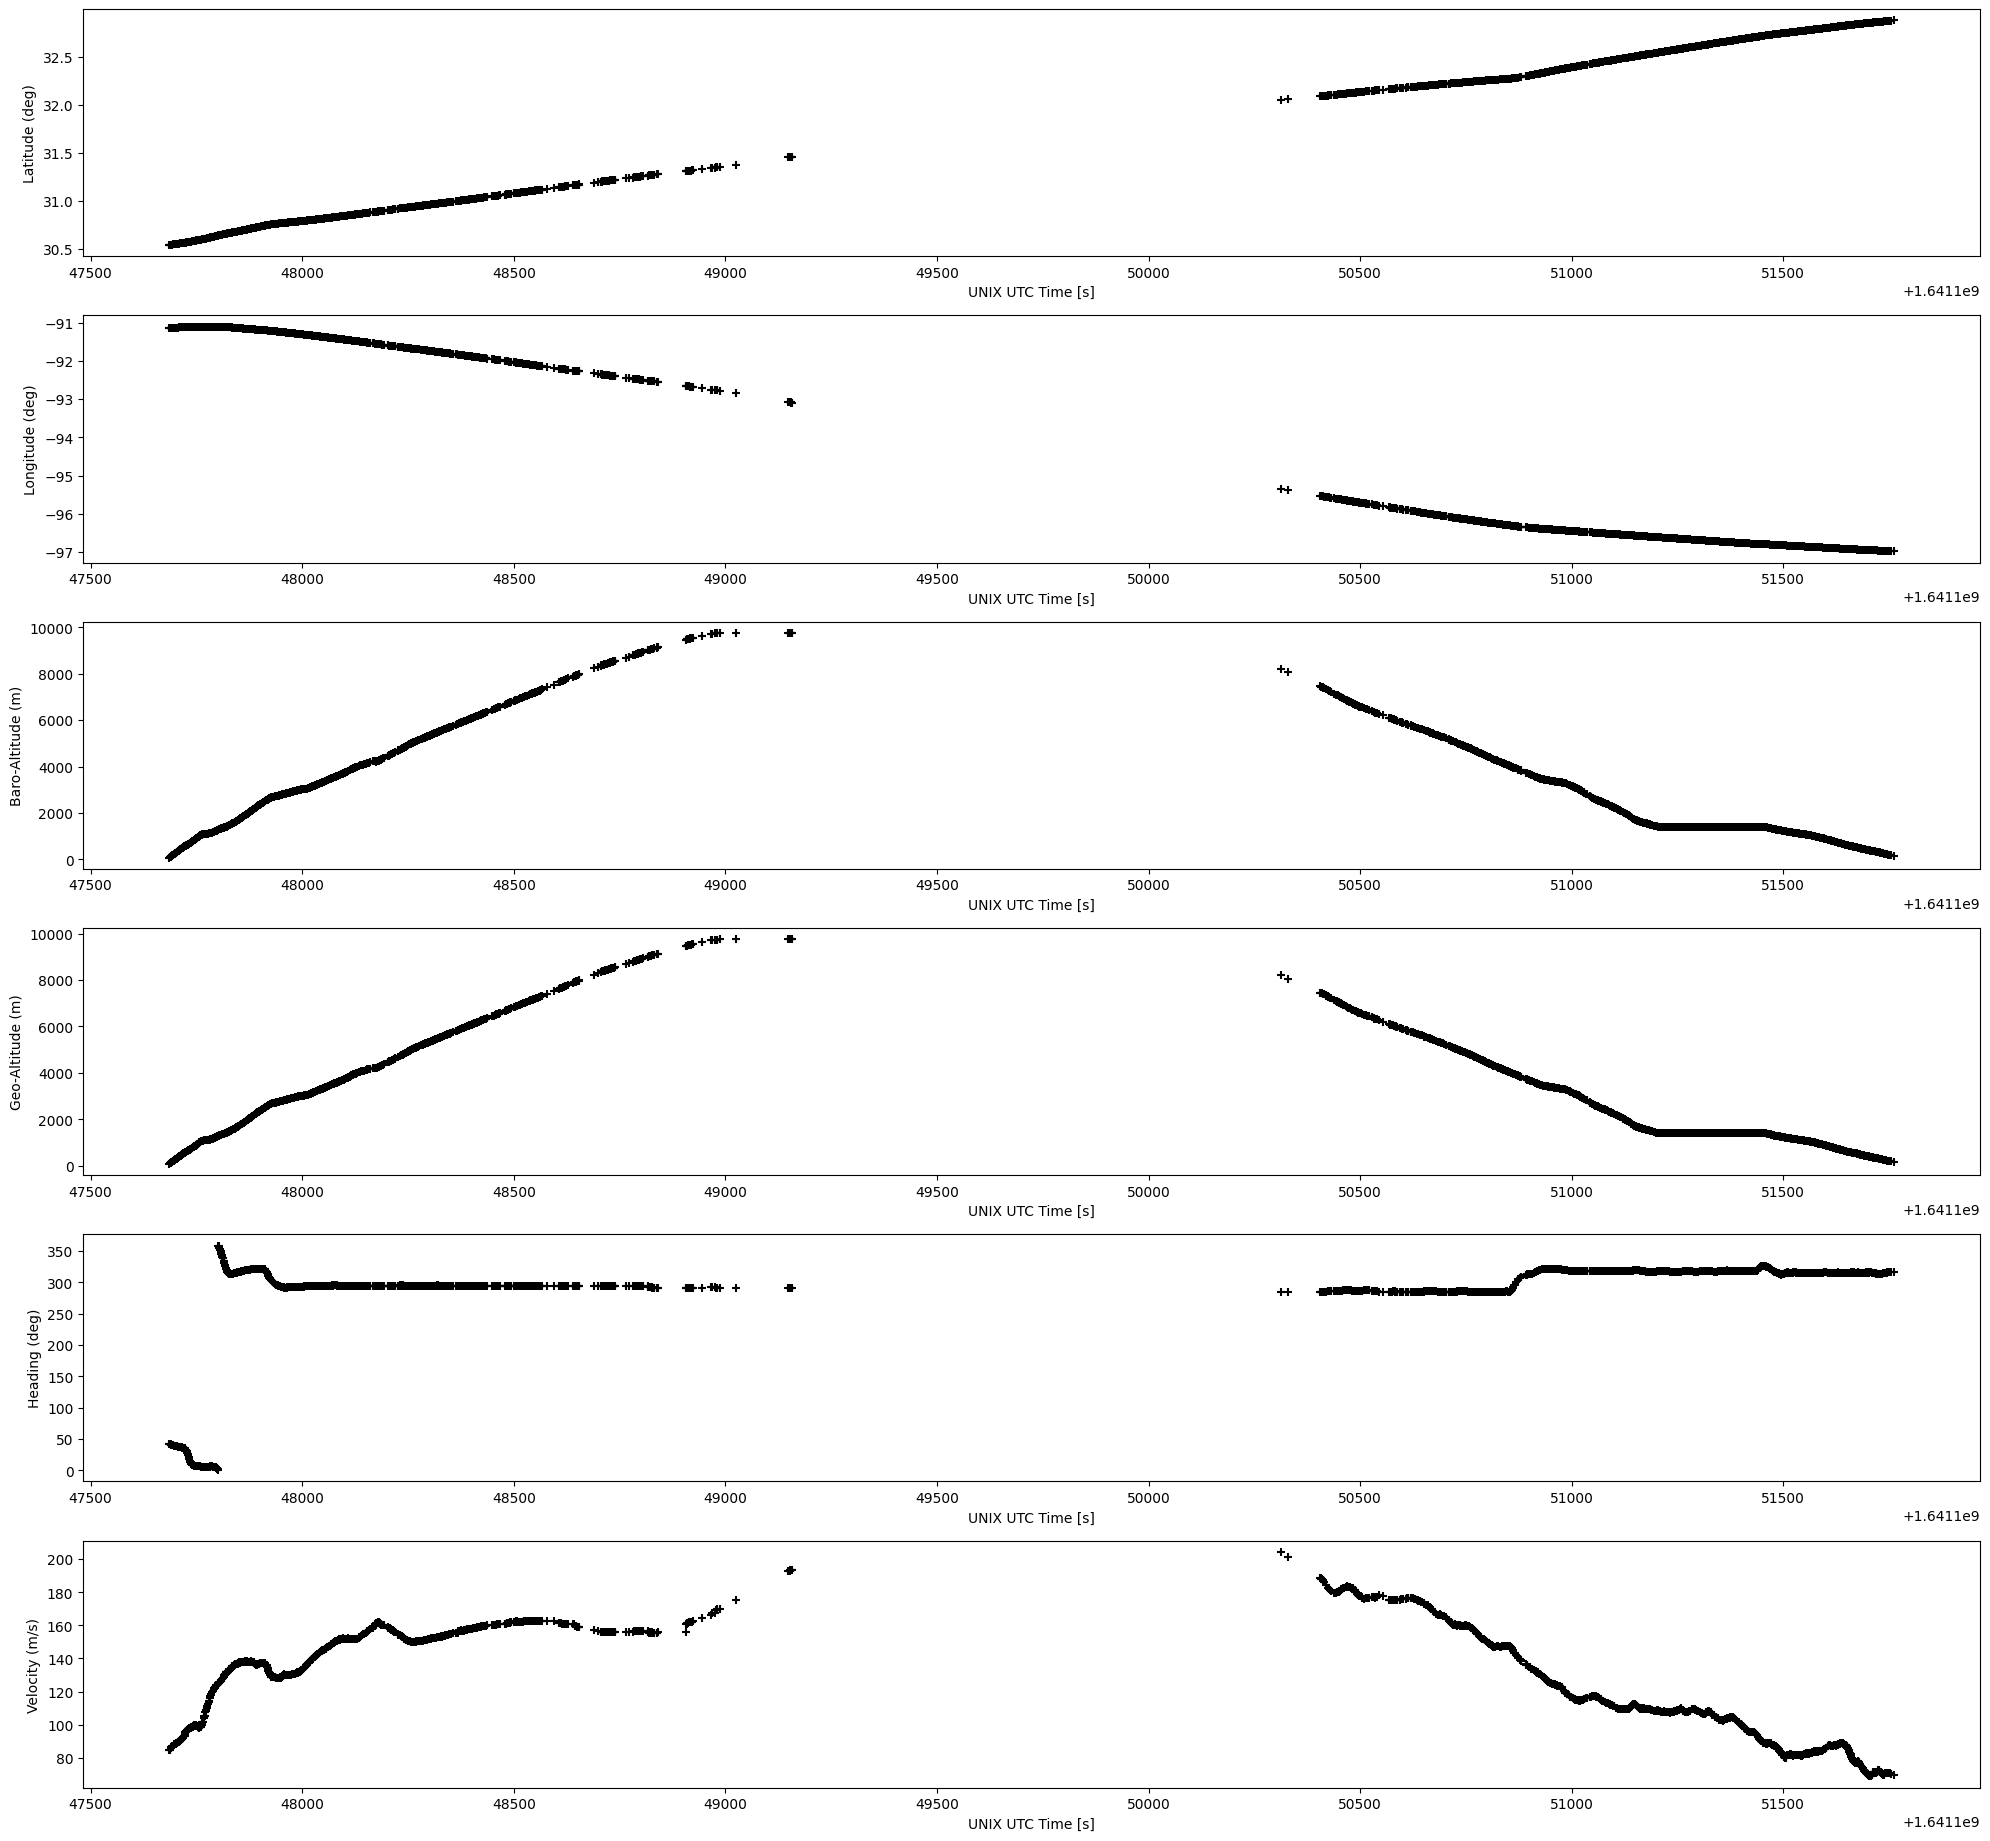

In [6]:
import numpy as np

# Let's choose a random flight out of the dataframe we got
flight = flights.sample(1).iloc[0]

# Similarly to querying flight data, there are 'bad hours' which can happen
state_vectors = opensky_querier.query_state_vectors(
                flight['icao24'],
                flight['firstseen'],
                flight['lastseen'])

# Checks if no sneaky strings make it into the rows
cols_to_check = ['time', 'lat', 'lon', 'velocity', 'heading', 'baroaltitude', 'geoaltitude', 'hour']
for col in cols_to_check:
    state_vectors[col] = state_vectors[col].apply(lambda x: np.nan if isinstance(x, str) else x)
state_vectors.dropna(inplace=True)

# This drops identical columns. If OpenSky does not have the data for some time, it just fills it with the previous (or sometimes future) datapoint, we don't want that, so we check to see if a row's lat and lon is repeated (that is, if the aircraft did not move), then we clean it.
cols_to_check = ['lat', 'lon']
state_vectors = state_vectors.drop_duplicates(subset=cols_to_check, keep='first')

fig, ax = plt.subplots(6, figsize = [20, 30/1.62])
ax[0].scatter(state_vectors['time'], state_vectors['lat'], color = 'k', marker = '+')
ax[0].set_xlabel('UNIX UTC Time [s]')
ax[0].set_ylabel('Latitude (deg)')

ax[1].scatter(state_vectors['time'], state_vectors['lon'], color = 'k', marker = '+')
ax[1].set_xlabel('UNIX UTC Time [s]')
ax[1].set_ylabel('Longitude (deg)')

ax[2].scatter(state_vectors['time'], state_vectors['baroaltitude'], color = 'k', marker = '+')
ax[2].set_xlabel('UNIX UTC Time [s]')
ax[2].set_ylabel('Baro-Altitude (m)')

ax[3].scatter(state_vectors['time'], state_vectors['baroaltitude'], color = 'k', marker = '+')
ax[3].set_xlabel('UNIX UTC Time [s]')
ax[3].set_ylabel('Geo-Altitude (m)')

ax[4].scatter(state_vectors['time'], state_vectors['heading'], color = 'k', marker = '+')
ax[4].set_xlabel('UNIX UTC Time [s]')
ax[4].set_ylabel('Heading (deg)')

ax[5].scatter(state_vectors['time'], state_vectors['velocity'], color = 'k', marker = '+')
ax[5].set_xlabel('UNIX UTC Time [s]')
ax[5].set_ylabel('Velocity (m/s)')

fig.tight_layout()

state_vectors.to_csv(f'{root_path}/data/example/flight/state_vectors_example.csv')

state_vectors

In [12]:
datetime.timedelta(weeks = 1).total_seconds()

604800.0

## 2. Compressing and Decompressing State Vector Data

This section covers the algorithm used to compress and decompress the state vector data. Beware that this is a lossy process. It's meant to capture the shape of each of the variables in the statevector, which minimizing the amount of data necessary for storage.

The first step is to normalize all the data between 0 and 1 but re-ranging it: $x -> (x - xmin)/(xmax - xmin)$.

Each curve of interest for each flight will be converted to a spline. The precision $s$ (s = 0 -> maximum precision) will be determined such that the spline will be the one that results with the smallest total length of coefficients and knots while minimizing s, and still passes the pearson correlation threshold against the original data.

Note: a small s will result in a better precision, but also more coefficients.
Note on the algorithm: 
 - First find the largest `s` that still passes the threshold
 - Thne find the smallest `s` that does not present a higher complexity (len(knots) + len(coeffs))
 
The information of the coefficients, knots, minimum and maxium of all variables is stored and used to reconstruct the original spline and data.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Compression Factor: 4.557239885815533
could not determine a constructor for the tag 'tag:yaml.org,2002:python/object/apply:numpy.core.multiarray.scalar'
  in "..//data/example/flight/example_splines.yml", line 30, column 9


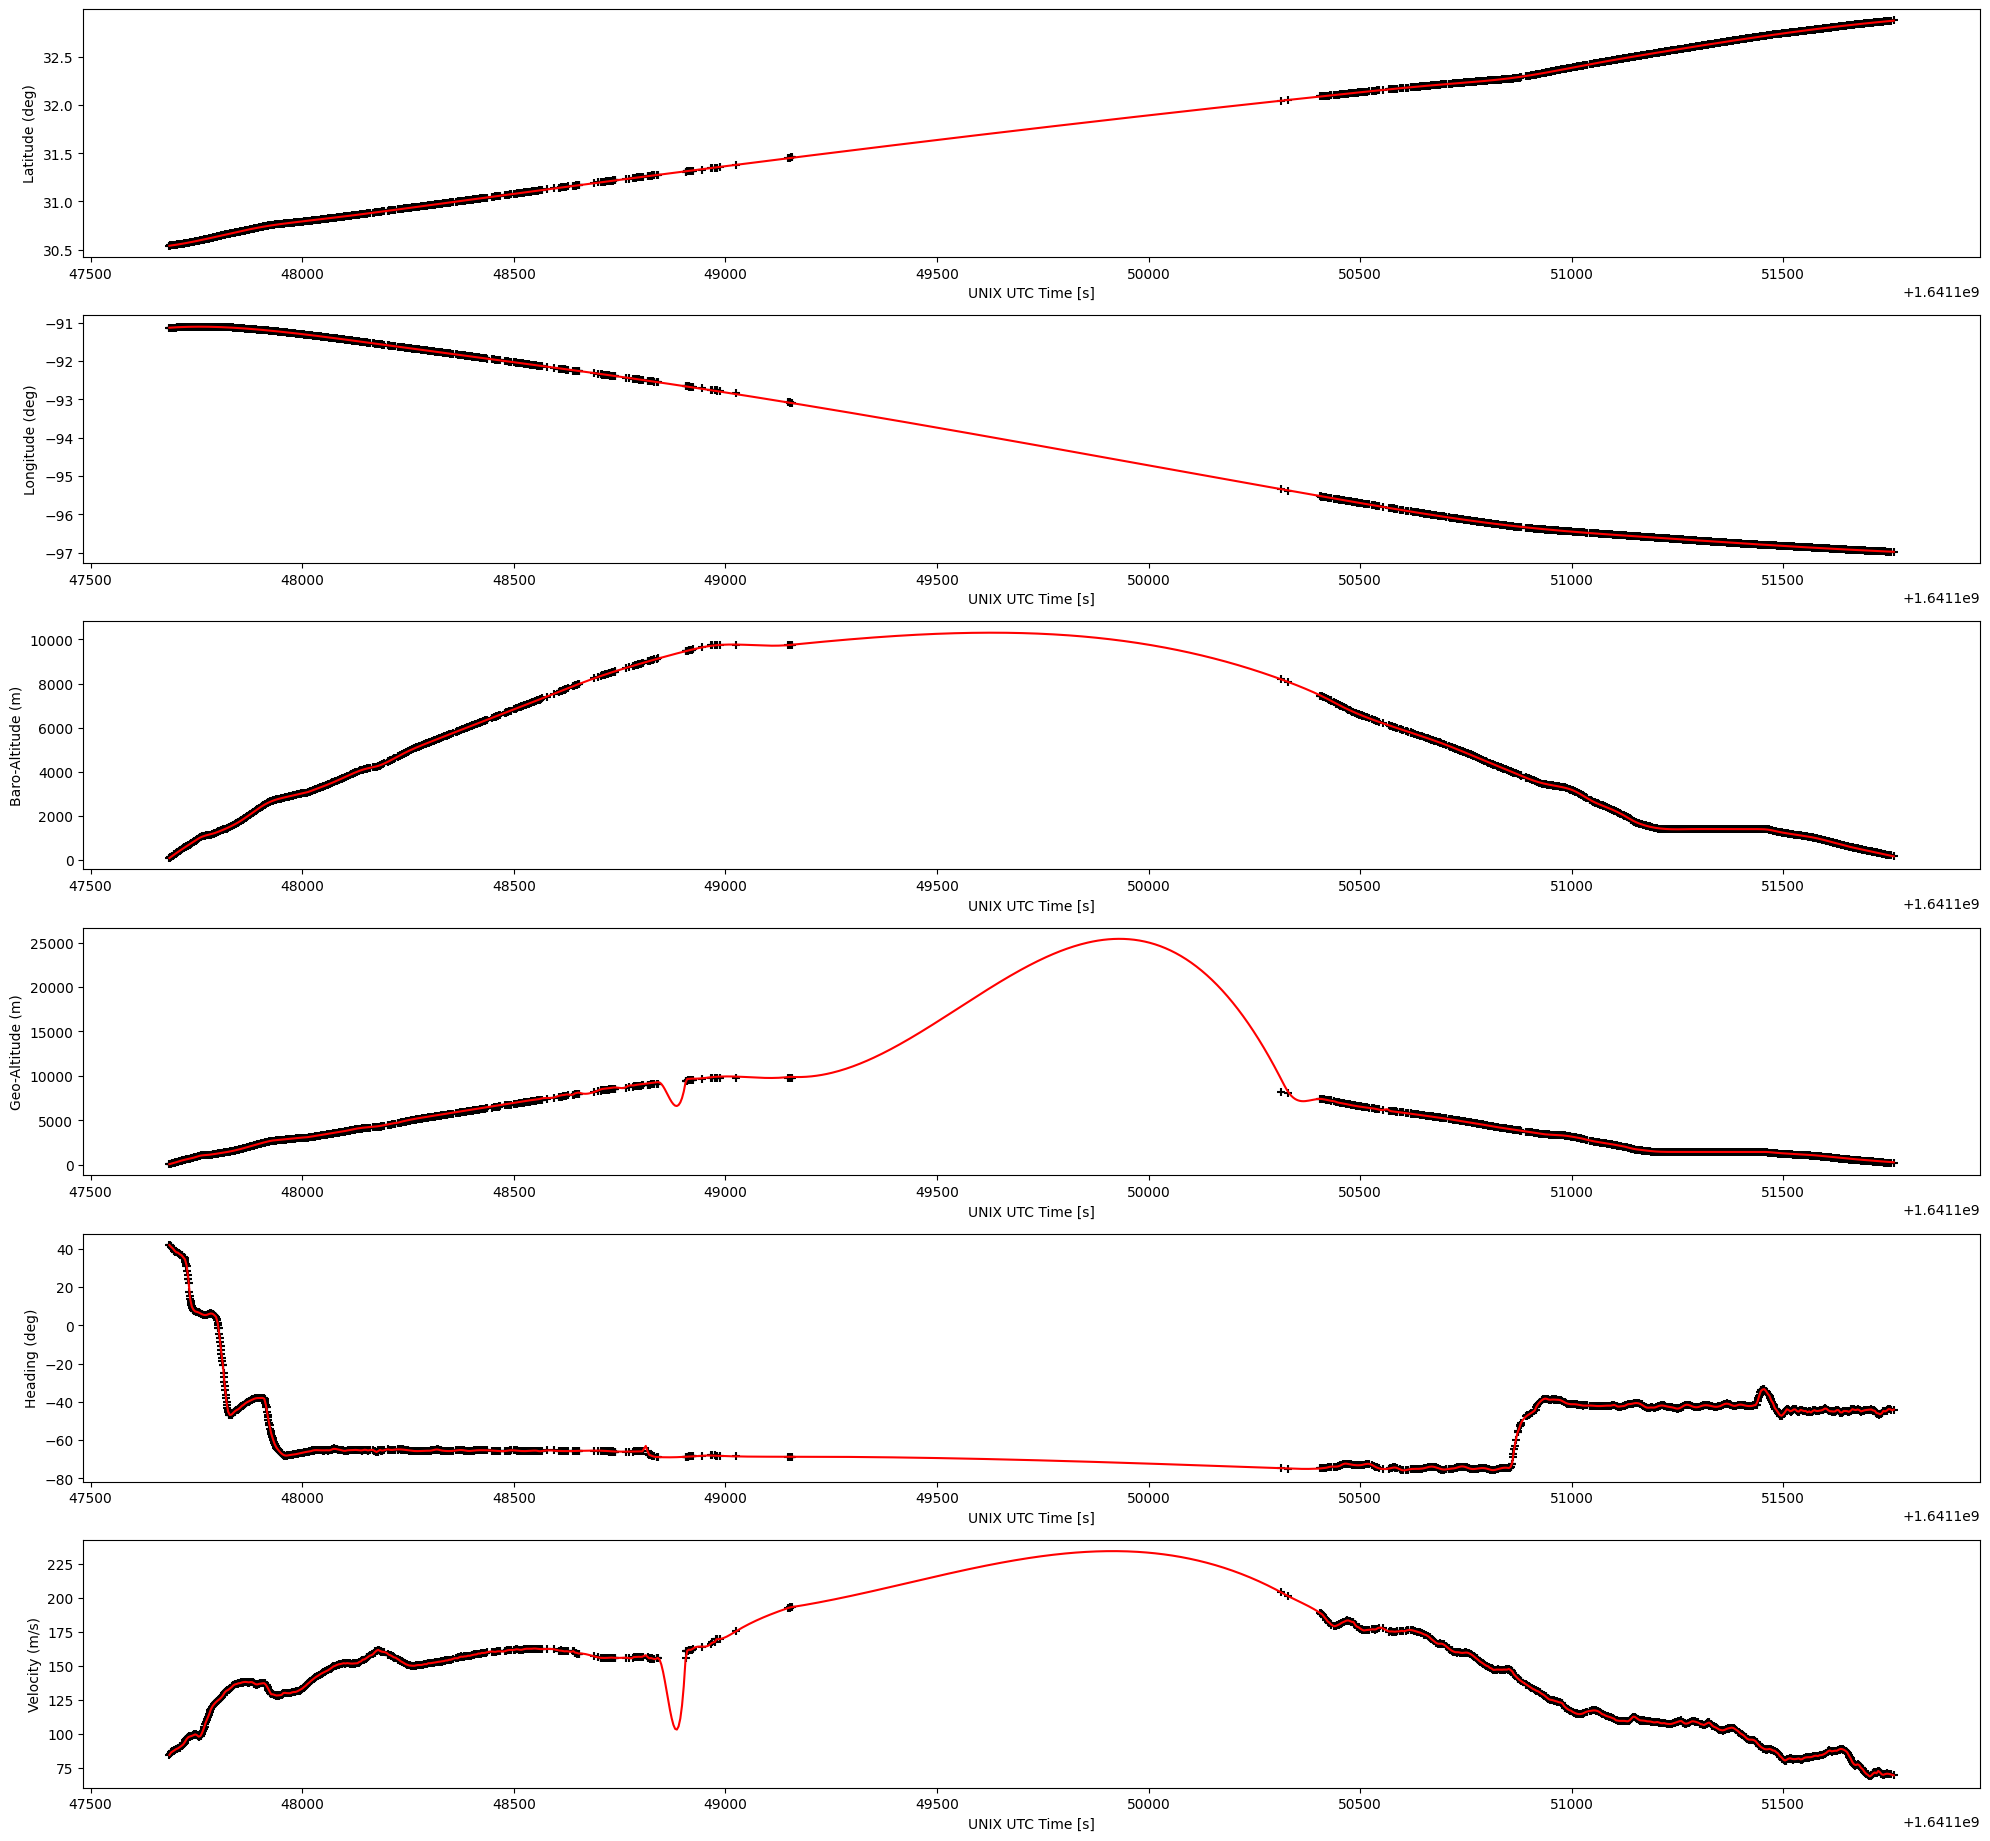

In [13]:
import matplotlib.pyplot as plt 
import datetime
import yaml
import pandas as pd
import numpy as np

# This variable should indicate the path from this Jupyter Notebook to the root directory of the repo.
root_path = '../'
# Adds the repo's root to the list of paths
import sys
sys.path.append(root_path)
# Package for downloading opensky data 
from src.backend import opensky_query
# Utilities package
from src.backend import utils
# Package used to compress state vectors data
from src.backend import compressors

# This is here for, if you change something in any of the files, you don't have to restart the kernel
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# From here we load the config file
with open(f'{root_path}/config/config.yml', 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

# Loading state vectos from csv, not needed if you just ran the steps above
state_vectors = pd.read_csv(f'{root_path}/data/example/flight/state_vectors_example.csv', index_col=0)

# Creates an instance of the SplineCompressor class.
compressor = compressors.SplineCompressor(config)

# List of columns of state_vectors to be compressed.
columns = ['lat', 'lon', 'baroaltitude', 'geoaltitude', 'heading', 'velocity']
# This method encodes the information from the columns into a dictionary, which can be used to recreate the data upon request.
metadata = compressor.encode_from_dataframe(state_vectors, 'time', columns)
# Computes the compression factor achieved as x_old/x_new.
compression_factor = compressor.compute_compression_factor(state_vectors['time'].values, state_vectors[columns].values, metadata)
print(f"Compression Factor: {compression_factor}")
# Turns dictionary data into the yaml format
yaml_data = yaml.dump(metadata, default_flow_style=None)
# Saves it to a yaml file
with open(f"{root_path}/data/example/flight/example_splines.yml", 'w') as f:
    f.write(yaml_data)
    
# We can now retrive the yaml file and reconstruct it
# From here we load the config file
with open(f"{root_path}/data/example/flight/example_splines.yml", 'r') as file:
    try:
        metadata = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

# This can then be saved to a yml file, it can be recovered from the method below (for now it just supports one column at a time)
# It returns a function for which an input x can be given and it will output the corresponding reconstructed data
spline_lat = compressor.decode_spline_single_column(metadata, 'lat')
spline_lon = compressor.decode_spline_single_column(metadata, 'lon')
spline_balt = compressor.decode_spline_single_column(metadata, 'baroaltitude')
spline_galt = compressor.decode_spline_single_column(metadata, 'geoaltitude')
spline_head = compressor.decode_spline_single_column(metadata, 'heading')
spline_vel = compressor.decode_spline_single_column(metadata, 'velocity')

fig, ax = plt.subplots(6, figsize = [20, 30/1.62])
x = np.linspace(metadata['lat']['xmin'], metadata['lat']['xmax'], num = 1000)

y_lat = spline_lat(x)
y_lon = spline_lon(x)
y_balt = spline_balt(x)
y_galt = spline_galt(x)
y_head = spline_head(x)
y_vel = spline_vel(x)

ax[0].scatter(state_vectors['time'], state_vectors['lat'], color = 'k', marker = '+')
ax[0].plot(x, y_lat, color = 'red')
ax[0].set_xlabel('UNIX UTC Time [s]')
ax[0].set_ylabel('Latitude (deg)')

ax[1].scatter(state_vectors['time'], state_vectors['lon'], color = 'k', marker = '+')
ax[1].plot(x, y_lon, color = 'red')
ax[1].set_xlabel('UNIX UTC Time [s]')
ax[1].set_ylabel('Longitude (deg)')

ax[2].scatter(state_vectors['time'], state_vectors['baroaltitude'], color = 'k', marker = '+')
ax[2].plot(x, y_balt, color = 'red')
ax[2].set_xlabel('UNIX UTC Time [s]')
ax[2].set_ylabel('Baro-Altitude (m)')

ax[3].scatter(state_vectors['time'], state_vectors['baroaltitude'], color = 'k', marker = '+')
ax[3].plot(x, y_galt, color = 'red')
ax[3].set_xlabel('UNIX UTC Time [s]')
ax[3].set_ylabel('Geo-Altitude (m)')

ax[4].scatter(state_vectors['time'], state_vectors['heading'], color = 'k', marker = '+')
ax[4].plot(x, y_head, color = 'red')
ax[4].set_xlabel('UNIX UTC Time [s]')
ax[4].set_ylabel('Heading (deg)')

ax[5].scatter(state_vectors['time'], state_vectors['velocity'], color = 'k', marker = '+')
ax[5].plot(x, y_vel, color = 'red')
ax[5].set_xlabel('UNIX UTC Time [s]')
ax[5].set_ylabel('Velocity (m/s)')

fig.tight_layout()

In [14]:
flight

firstseen              1641147684
lastseen               1641151763
callsign                  ENY3536
icao24                     a81db0
estdepartureairport          KBTR
estarrivalairport            KDFW
day                    1641081600
Name: 4, dtype: object

# 3. Plotting and Finding Flight Paths

This part is still ongoing, I have not done serious coding for the steps below, only the steps above

## 3.1 Loading compressed flight data for a single flight, recreating spline, and recreating data.

Note, this requires the existence of at least one `yml` file containig the flight. If there's none, you can download it from [here]

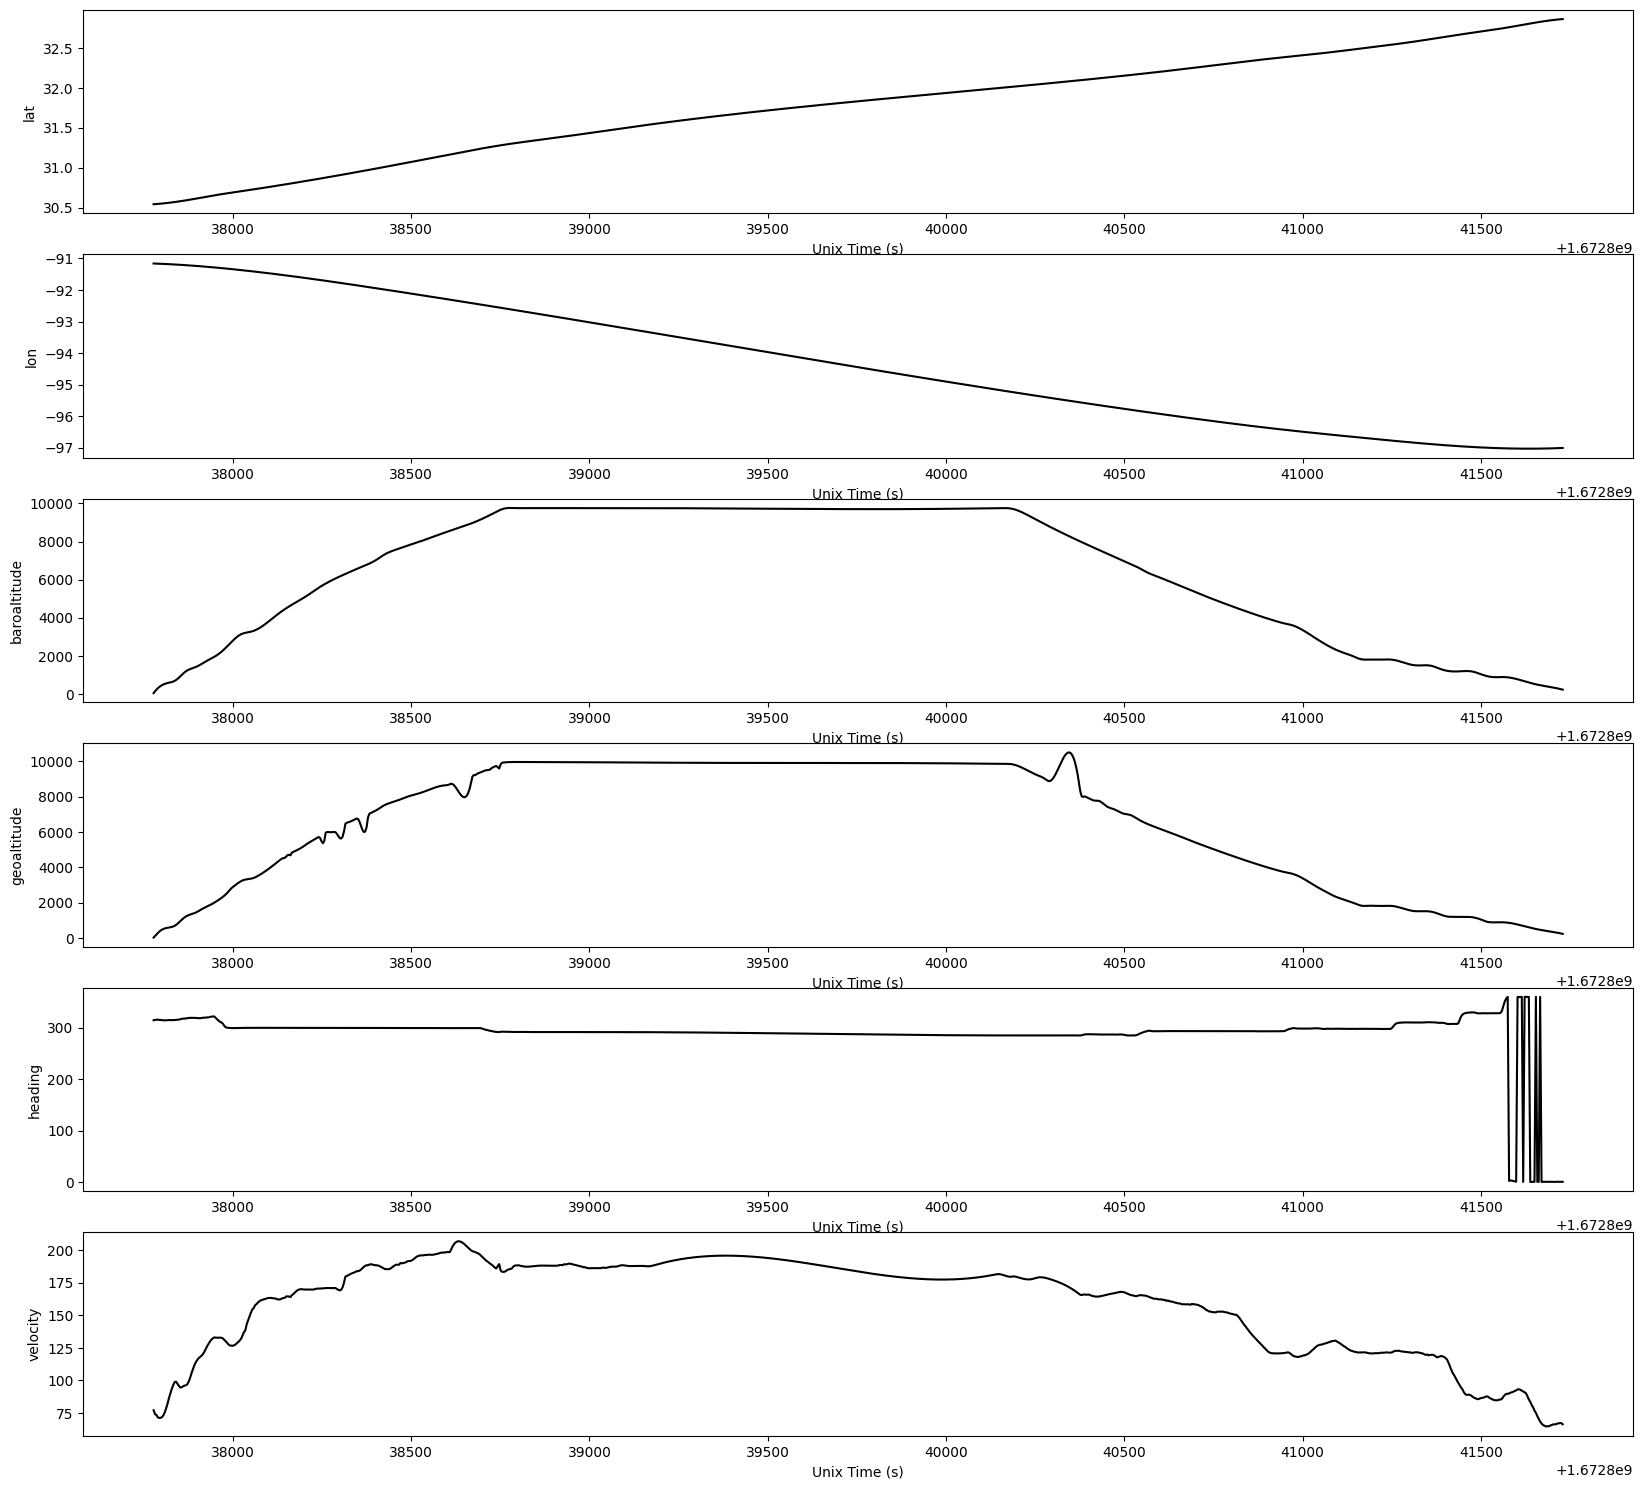

In [77]:
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# This variable should indicate the path from this Jupyter Notebook to the root directory of the repo.
root_path = '../'
# Adds the repo's root to the list of paths
import sys
sys.path.append(root_path)
# Utilities package
from src.backend import utils
# Package used to compress state vectors data
from src.backend import compressors

data_directory = '../data/flight/'
filename = 'a263dc_1672837778_1672841729_KBTR_KDFW.yml'

# From here we load the config file
with open(f'{root_path}/config/config.yml', 'r', encoding='utf8') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

with open(f'{data_directory}/{filename}', 'r', encoding='utf8') as file:
    try:
        metadata = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

xs = np.linspace(metadata['lat']['xmin'], metadata['lat']['xmax'], num=1000)
compressor = compressors.SplineCompressor(config)
columns = ['lat', 'lon', 'baroaltitude', 'geoaltitude', 'heading', 'velocity']
splines = {col:compressor.decode_spline_single_column(metadata, col) for col in columns}

ys = {col:splines[col](xs) for col in columns}
ys['lat'] = np.mod(ys['lat'], 360)
ys['heading'] = np.mod(ys['heading'], 360)


fig, ax = plt.subplots(len(columns), figsize = [20, 30/1.62])
for i, col in enumerate(columns):
    ax[i].plot(xs, ys[col], color = 'k')
    ax[i].set_xlabel('Unix Time (s)')
    ax[i].set_ylabel(f'{col}')

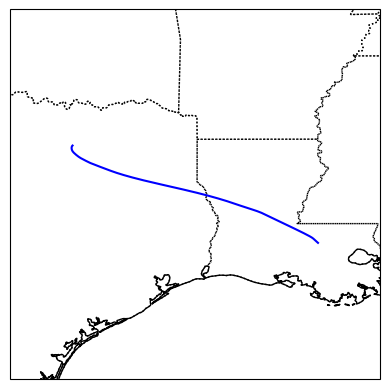

In [44]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':')

range_lat = max(ys['lat']) - min(ys['lat'])
range_lon = max(ys['lon']) - min(ys['lon'])
RANGE = max([range_lon, range_lat])*1.5
mid_lat = (max(ys['lat']) + min(ys['lat']))/2
mid_lon = (max(ys['lon']) + min(ys['lon']))/2
extent = [mid_lon - RANGE/2, mid_lon + RANGE/2, mid_lat - RANGE/2, mid_lat + RANGE/2]
ax.set_extent(extent)

# ax.plot(ys['lat'], ys['lon'], marker='o', color='blue', markersize=5, label='City', linestyle='-', transform=ccrs.Geodetic())
ax.plot(ys['lon'], ys['lat'], color='blue', transform=ccrs.PlateCarree())


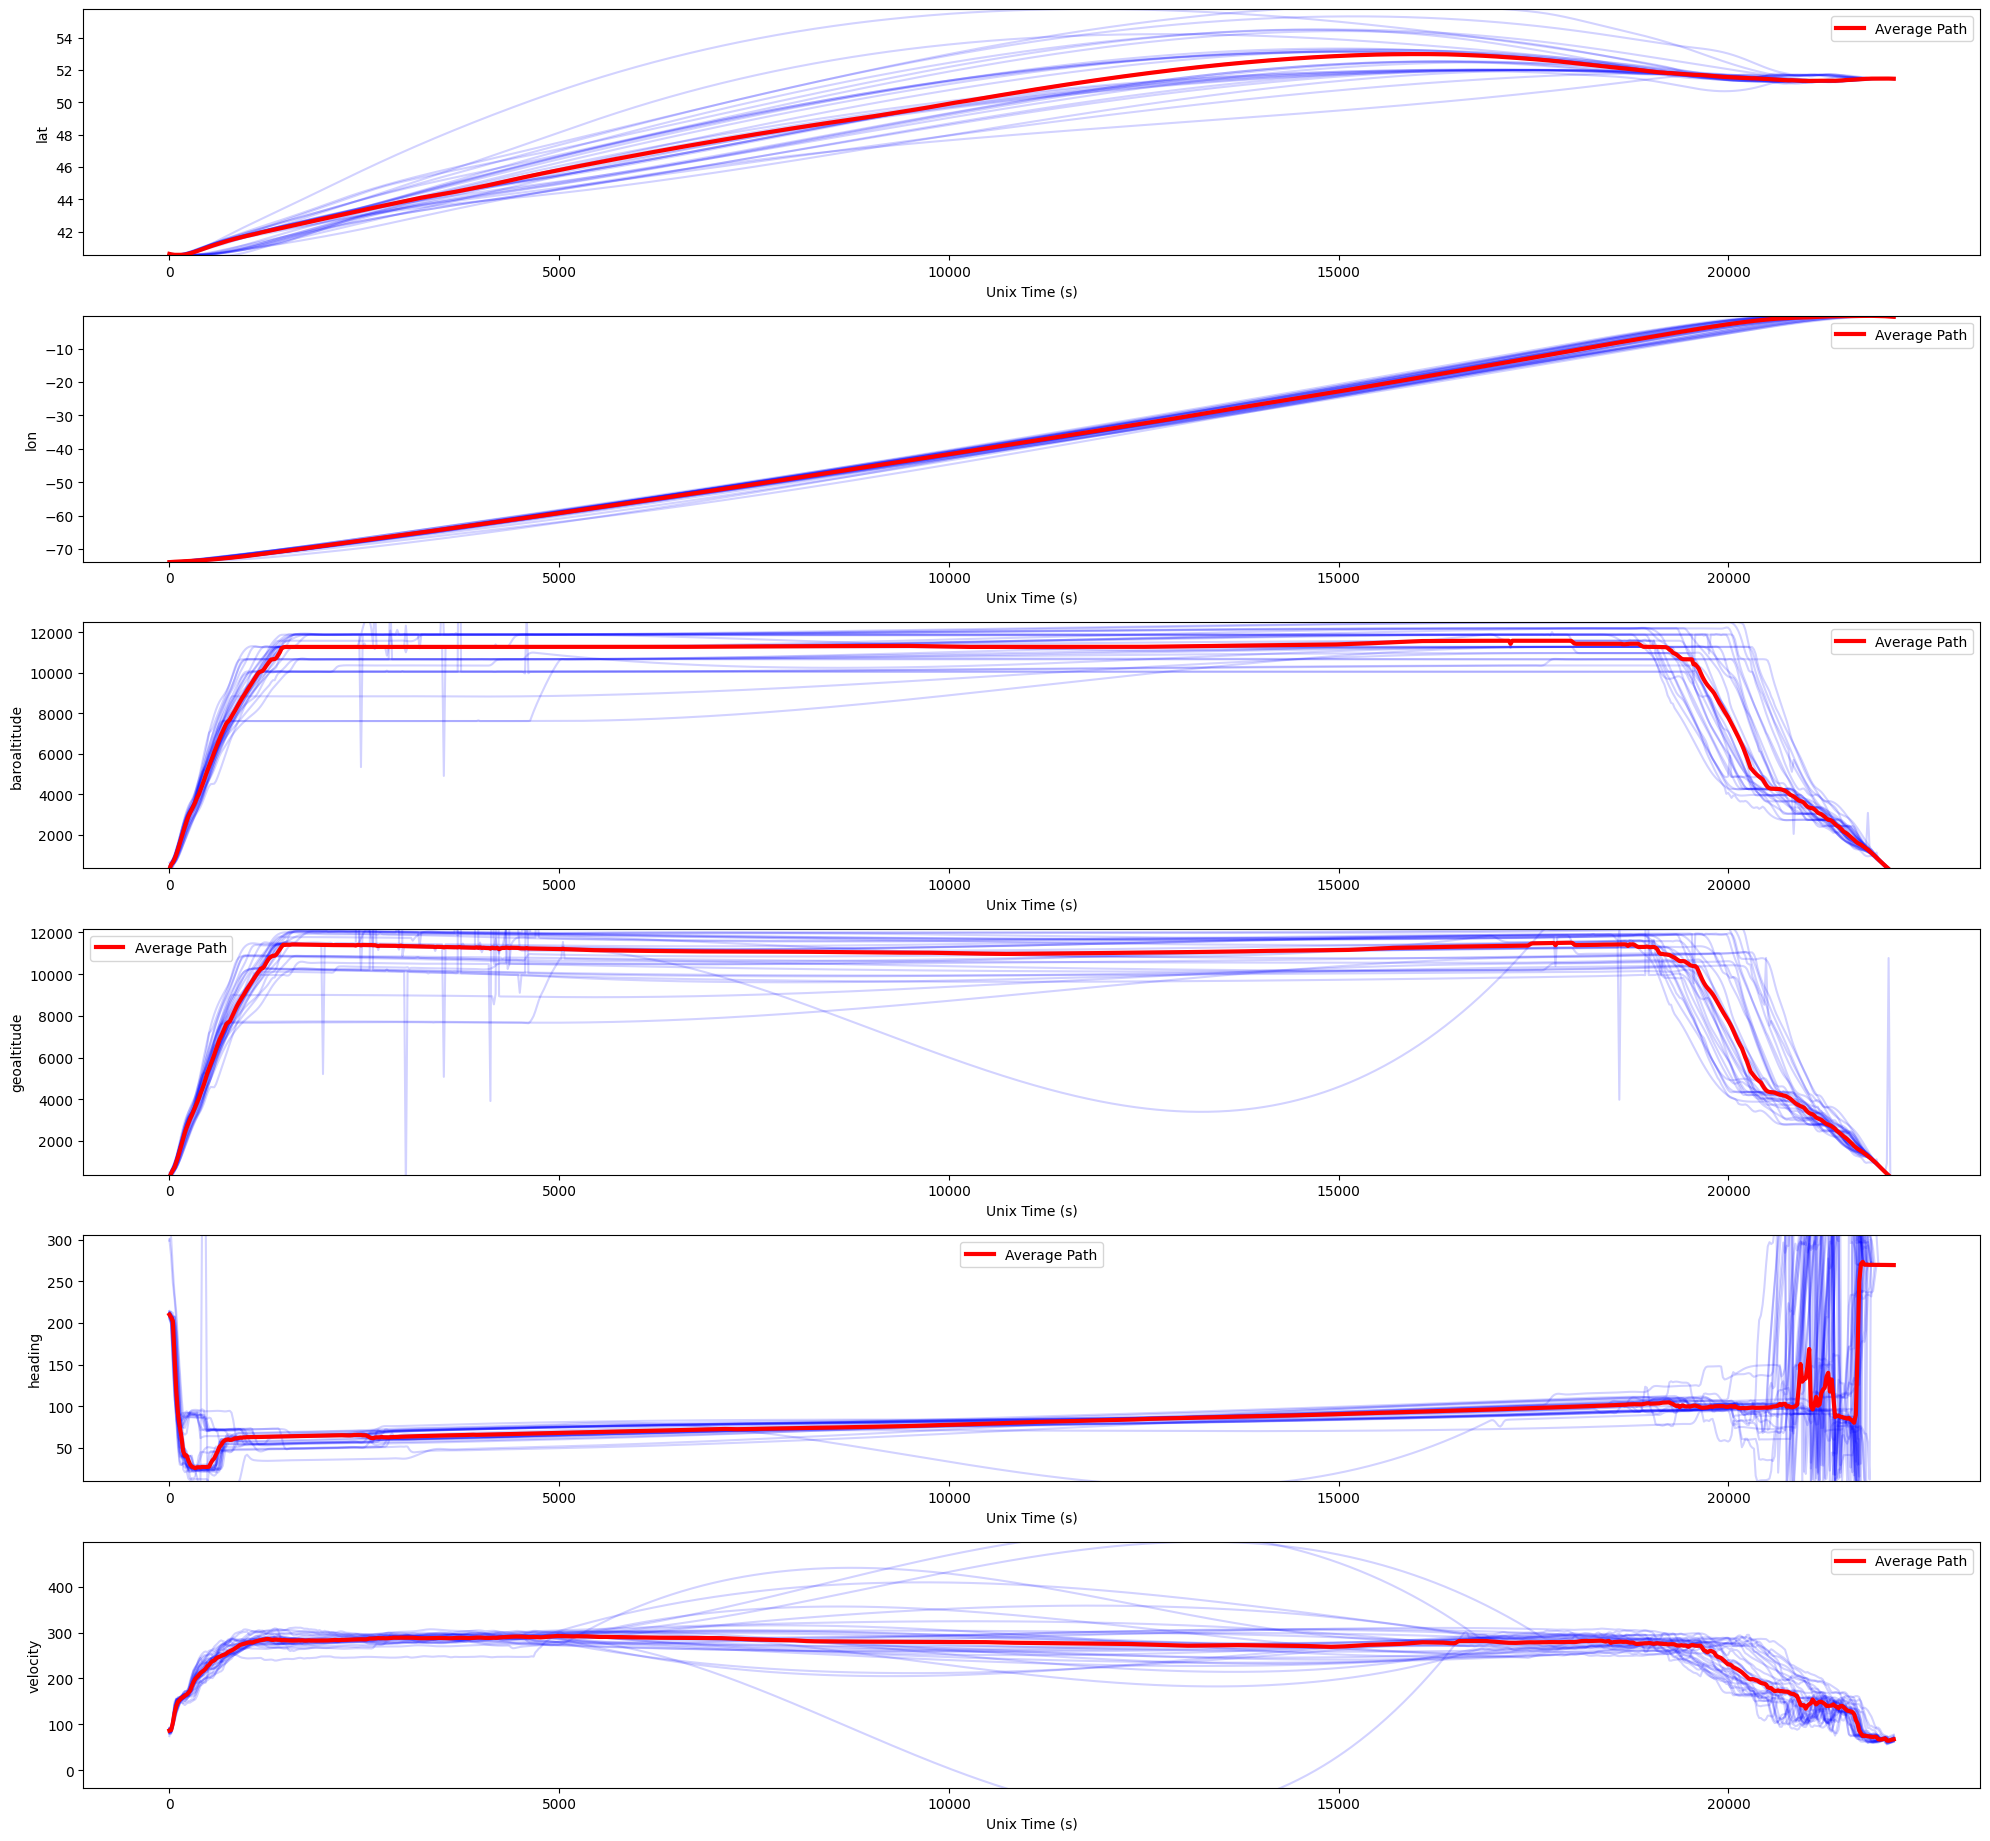

In [97]:
import os
files = [f'{f}' for f in os.listdir(data_directory) if f.endswith('.yml') and 'KJFK' in f]

ys = np.zeros((len(files), len(columns), 1000))
total_ts = np.zeros(len(files))
for i, filename in enumerate(files):
    with open(f'{data_directory}/{filename}', 'r', encoding='utf8') as file:
        try:
            metadata = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(exc)

    xs = np.linspace(metadata['lat']['xmin'], metadata['lat']['xmax'], num=1000)
    total_ts[i] = xs[-1] - xs[0]
    compressor = compressors.SplineCompressor(config)
    columns = ['lat', 'lon', 'baroaltitude', 'geoaltitude', 'heading', 'velocity']
    splines = {col:compressor.decode_spline_single_column(metadata, col) for col in columns}
    for j, col in enumerate(columns):
        ys[i, j] = splines[col](xs).copy()
        if col == 'lat' or col == 'heading':
            ys[i, j] = np.mod(ys[i, j], 360)
    
means = np.median(ys, axis = 0)
xs = np.linspace(0, np.mean(total_ts), num = 1000)

fig, ax = plt.subplots(len(columns), figsize = [20, 30/1.62])
for i, col in enumerate(columns):
    for j, file in enumerate(files):
        ax[i].plot(xs, ys[j, i], color = 'b', alpha=1/np.sqrt(len(files)))
        ax[i].set_xlabel('Unix Time (s)')
        ax[i].set_ylabel(f'{col}')
    ax[i].set_ylim([np.percentile(ys[:, i], 0.5), np.percentile(ys[:, i], 99.5)])
    ax[i].plot(xs, means[i], color = 'r', label = 'Average Path', linewidth = 3)
    ax[i].legend()
fig.tight_layout()

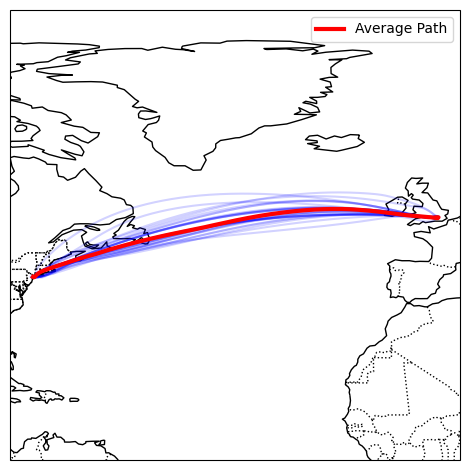

In [126]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':')

for i, file in enumerate(files):
    ax.plot(ys[i,1,:], ys[i,0,:], color = 'b', alpha=1/np.sqrt(len(files)))
ax.plot(means[1], means[0], color = 'r', linewidth = 3, label = 'Average Path')

x_min, x_max, y_min, y_max = ax.get_extent()
RANGE = np.max([y_max - y_min, x_max - x_min])
y_mid = (y_max + y_min)/2
x_mid = (x_max + x_min)/2
ax.set_extent([x_mid - RANGE/2, x_mid + RANGE/2, y_mid - RANGE/2, y_mid + RANGE/2])

ax.legend()
fig.tight_layout()

(-180.0, 180.0, -90.0, 90.0)